# Initalize libraries

## Import libraries

In [1]:
import sys, os
import time
from os.path import join
from os import path
from importlib import reload
from getpass import getuser
import xarray as xr
import h5py
from tqdm.auto import tqdm

sys.path.append(
    "/asap3/petra3/gpfs/p04/2023/data/11019143/shared/ck//library"
)

import numpy as np
import matplotlib.pyplot as plt

# Misc
from scipy.ndimage import gaussian_filter1d

# Open nexus files
from nexusformat.nexus import *

# Self-written libraries
import support_functions as sup

# Gifs
import imageio

plt.rcParams["figure.constrained_layout.use"] = True  # replaces plt.tight_layout

In [2]:
# Is there a GPU?
try:
    # Cupy
    import cupy as cp
    import cupyx as cpx

    GPU = True

    print("GPU available")

    # Self-written library
    import CCI_core_cupy as cci
except:
    GPU = False
    import CCI_core as cci

    print("GPU unavailable")

GPU unavailable


In [3]:
# interactive plotting
import ipywidgets
%matplotlib widget

# Auto formatting of cells
%load_ext jupyter_black

## Experiment specific Functions

In [4]:
PROPOSAL = 11019143
USER = getuser()

In [5]:
BASEFOLDER = "/asap3/petra3/gpfs/p04/2023/data/%s/" % PROPOSAL
subfolder = "FGT"
sample_name = "2310_FGT"


# Load any kind of data from collection
def load_collection(scan_id, field):
    fname = join(BASEFOLDER, "raw", subfolder, "%s_%05d.nxs" % (sample_name, scan_id))

    with nxload(fname) as f:
        data = f["scan"]["instrument"]["collection"][field][()]
        print("Loaded: %s" % (fname))
    return data


# Load any kind of data from collection
def load_energy(scan_id):
    fname = join(BASEFOLDER, "raw", subfolder, "%s_%05d.nxs" % (sample_name, scan_id))

    with nxload(fname) as f:
        data = f["scan"]["instrument"]["mono"]["energy"][()]
        print("Loaded: %s" % (fname))
    return data


# Load any kind of data from measurements
def load_data(scan_id, field):
    fname = join(BASEFOLDER, "raw", subfolder, "%s_%05d.nxs" % (sample_name, scan_id))

    with nxload(fname) as f:
        data = f["scan"]["data"][field][()]
        print("Loaded key %s of %s" % (field, fname))
    return data

In [48]:
# Not implemented yet
def norm_hyst_data(ydata, norm):
    """
    Normalize hysteresis yaxis to +/- 1
    """
    ynorm = []
    for i in range(len(ydata)):
        tmp = ydata[i] / norm[i]
        tmp = tmp - np.mean(tmp[-5:])
        tmp = tmp / np.mean(tmp[:5])
        tmp = 2 * (tmp - 0.5)
        ynorm.append(tmp)

    return ynorm

# Experimental Details

In [6]:
# Dict with most basic experimental parameter
experimental_setup = {
    "ccd_dist": 0.30,  # ccd to sample distance
    "energy": 707,  # x-ray energy
    "px_size": 15e-6,  # pixel_size of camera
    "binning": 1,  # Camera binning
}

# Convert eV to wavelength
experimental_setup["lambda"] = cci.photon_energy_wavelength(
    experimental_setup["energy"], input_unit="eV"
)

# General saving folder
folder_general = sup.create_folder(join(BASEFOLDER, "processed"))
print("Output Folder: %s" % folder_general)

Output Folder: /asap3/petra3/gpfs/p04/2023/data/11019143/processed


# Single Diode scans

In [34]:
# Add scan numbers to combine in plot
scan_ids = [1426]

# keys from nxs files (if you are not sure, which you need, open nexus files from beamtime folder and navigate through keys `2310_P04_FGT/raw/FGT`)
data_key_x = "msz"
data_key_y = "beckADC1mean"

# Normalization of diode signal, e.g., with petra current or gold mesh
normalization = False
data_key_norm = "beckADC2mean"  # "petra_curr"

# Load data
xdata = []
ydata = []
norm = []
for scan_id in tqdm(scan_ids):
    xdata.append(np.array(load_data(scan_id, data_key_x)))
    ydata.append(np.array(load_data(scan_id, data_key_y)))

    if normalization is True:
        norm.append(np.array(load_data(scan_id, data_key_norm)))
    else:
        norm.append(np.ones(np.array(load_data(scan_id, data_key_y)).shape))

# Convert to array
xdata = np.array(xdata)
ydata = np.array(ydata)
norm = np.array(norm)

  0%|          | 0/1 [00:00<?, ?it/s]

Loaded key msz of /asap3/petra3/gpfs/p04/2023/data/11019143/raw/FGT/2310_FGT_01426.nxs
Loaded key beckADC1mean of /asap3/petra3/gpfs/p04/2023/data/11019143/raw/FGT/2310_FGT_01426.nxs
Loaded key beckADC1mean of /asap3/petra3/gpfs/p04/2023/data/11019143/raw/FGT/2310_FGT_01426.nxs


Saving: /asap3/petra3/gpfs/p04/2023/data/11019143/processed/ScanId_1426-1426_Diode_lisakern.png


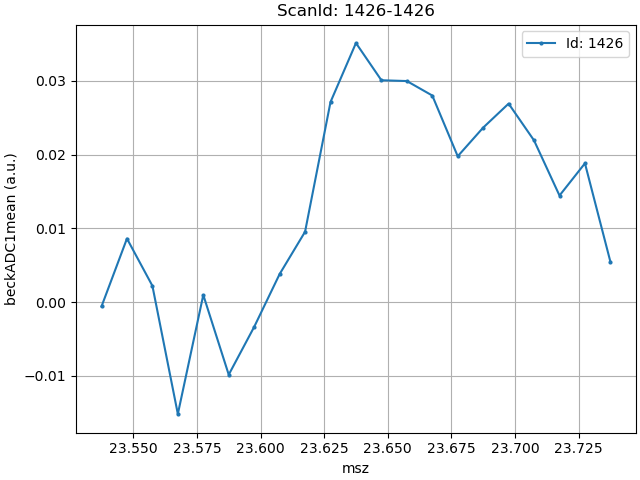

In [35]:
# Plot all scans together
fig, ax = plt.subplots()

# iterate over scans
for i, _ in enumerate(scan_ids):
    ax.plot(
        xdata[i],
        ydata[i] / norm[i],
        "o-",
        markersize=2,
        label="Id: %d" % scan_ids[i],
    )

# Plotting options
ax.set_title("ScanId: %04d-%04d" % (scan_ids[0], scan_ids[-1]))
ax.set_xlabel(data_key_x)
# ax.set_xlim([-0.01, 0.01])
# ax.set_ylim([-0.015, 0.015])

if normalization is True:
    ax.set_ylabel(data_key_y + " (normalized by %s)" % data_key_norm)
else:
    ax.set_ylabel(data_key_y + " (a.u.)")
ax.grid()
ax.legend()

# Save plot
fname = join(
    folder_general, "ScanId_%04d-%04d_Diode_%s.png" % (scan_ids[0], scan_ids[-1], USER)
)
print("Saving: %s" % fname)
plt.savefig(fname, dpi=300)

# Diode Trace Hysteresis

In [23]:
def ramp_tan(npts: int, s: float, full=False):
    """Calculate truncated tangent ramp function.

    Parameters
    ==========
    npts: int
        Number of points to calculate
    s: float
        shape parameter (0<s≤1) varies curve from linear (s→0) to tan-shaped
    full: bool
        If True, return both arms of the loop by mirroring. This effectively
        doubles the number of points.

    Returns
    =======
    ramp: np.ndarray
        normalized ramp values
    """
    # if (s <= 0) or (s > 1):
    #     raise ValueError("shape parameter out of range 0<s≤1")
    x = s * np.linspace(-np.pi / 2, np.pi / 2, npts)
    y = np.tan(x) / np.tan(np.pi * s / 2)
    if full:
        y = np.append(y, y[::-1][1:])
    return y

In [24]:
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

In [53]:
# Choose scan id
scan_id = 1098  # BSCCO
temperature = 342

# Load trace data
fields = [f"beckadc{i}" for i in range(1, 4)]
adcs = [load_data(scan_id, f) for f in fields]

Loading field beckadc1 of /asap3/petra3/gpfs/p04/2023/data/11016769/raw/nxs/2306_XPCS_01098.nxs
Loading field beckadc2 of /asap3/petra3/gpfs/p04/2023/data/11016769/raw/nxs/2306_XPCS_01098.nxs
Loading field beckadc3 of /asap3/petra3/gpfs/p04/2023/data/11016769/raw/nxs/2306_XPCS_01098.nxs


In [54]:
# Create xarray dataset
ds = xr.Dataset()
ds["fields"] = ("index", adcs[2][:, 10:-10].flatten())  # magnetic field
ds["diode"] = ("index", adcs[0][:, 10:-10].flatten())  # diode current
ds["mesh"] = ("index", adcs[1][:, 10:-10].flatten())  # mesh current for normalization
ds["rising"] = (
    "index",
    gaussian_filter1d(np.gradient(ds["fields"]), 20) > 0,
)  # which hysteresis branch

In [55]:
bins = 0.5 * ramp_tan(80, 0.1, False)

ds_sel = ds
# ds_fit = ds.sel(index=range(9000))
ds_sel["rising"] = ds_sel.rising.astype(bool)
up = ds_sel.where(ds_sel.rising).groupby_bins("fields", bins).mean()
down = ds_sel.where(~ds_sel.rising).groupby_bins("fields", bins).mean()

In [56]:
# Cryostat temperature if save in nxs file
data_key = "cryob"
temperature = np.mean(np.array(load_data(scan_id, data_key)))

Loading field cryob of /asap3/petra3/gpfs/p04/2023/data/11016769/raw/nxs/2306_XPCS_01098.nxs


NeXusError: Invalid path

In [ ]:
fig, ax = plt.subplots()
ax.plot(ds["diode"])
ax2 = ax.twinx()
ax.plot(ds["fields"] / 10 + 0.05)

Saving: /asap3/petra3/gpfs/p04/2023/data/11016769/processed/ScanId_1098_Diode_Trace_cklose.png


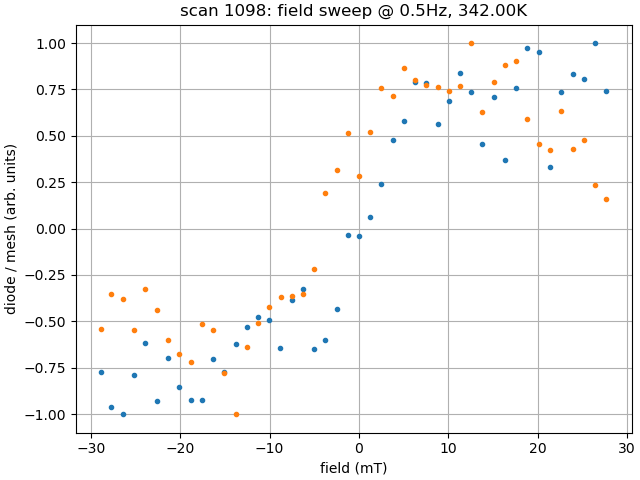

In [57]:
fig, ax = plt.subplots()
ax.plot(1e2 * up.fields, 2 * normalize(up.diode / up.mesh) - 1, "o", ms=3)
ax.plot(1e2 * down.fields, 2 * normalize(down.diode / down.mesh) - 1, "o", ms=3)
ax.set_xlabel("field (mT)")
ax.set_ylabel("diode / mesh (arb. units)")
ax.set_title("scan %d: field sweep @ 0.5Hz, %.2fK" % (scan_id, temperature))
ax.grid()

fname = join(folder_general, "ScanId_%04d_Diode_Trace_%s.png" % (scan_id, USER))
print("Saving: %s" % fname)
plt.savefig(fname, dpi=300)

# Diode Traces

In [7]:
scan_ids = [88]
data_key_x = "br1_master"
data_key_y = "beckADC1"

xdata = []
ydata = []
for scan_id in tqdm(scan_ids):
    xdata.append(np.array(load_data(scan_id, data_key_x)))
    ydata.append(np.array(load_data(scan_id, data_key_y)))

  0%|          | 0/1 [00:00<?, ?it/s]

Loaded field br1_master of /asap3/petra3/gpfs/p04/2023/data/11015791/raw/230622_setup_00175.nxs
Loaded field beckADC1 of /asap3/petra3/gpfs/p04/2023/data/11015791/raw/230622_setup_00175.nxs


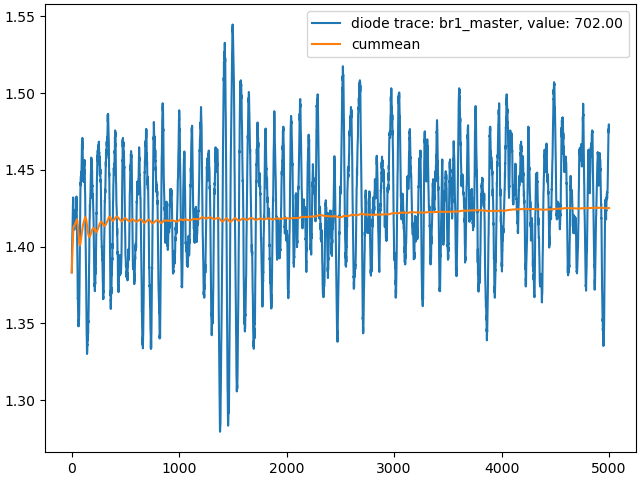

In [32]:
fig, ax = plt.subplots()
for i in range(0, 1):
    data_trace = ydata[0][i]
    cummean = np.cumsum(data_trace) / np.cumsum(np.ones(data_trace.shape))
    ax.plot(
        data_trace,
        label="diode trace: %s, value: %.2f" % (data_key_x, np.round(xdata[0][i], 2)),
    )
    ax.plot(cummean, label="cummean")
    ax.legend()

(0.0, 50.0)

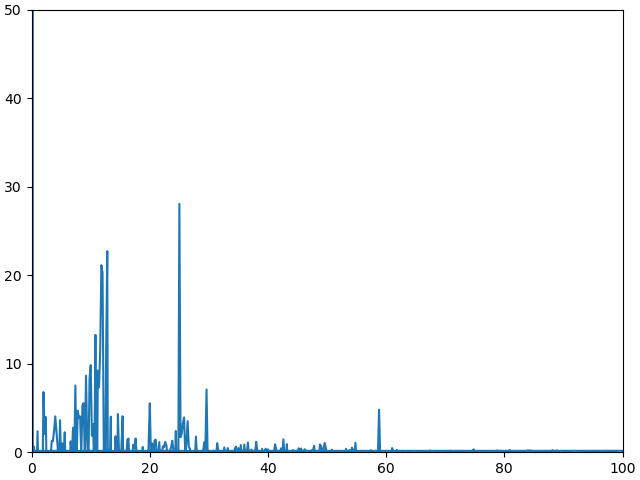

In [55]:
fig, ax = plt.subplots()
# time = np.arange(0, data_trace.shape[0]).astype(int)  # in s
ax.plot(np.fft.fftfreq(data_trace.shape[0], 1e-3), np.fft.fft(data_trace))
ax.set_xlim([0, 100])
ax.set_ylim([0, 50])

Saving: /asap3/petra3/gpfs/p04/2023/data/11015791/processed/ImId_0175-0175_Diode_cklose.png


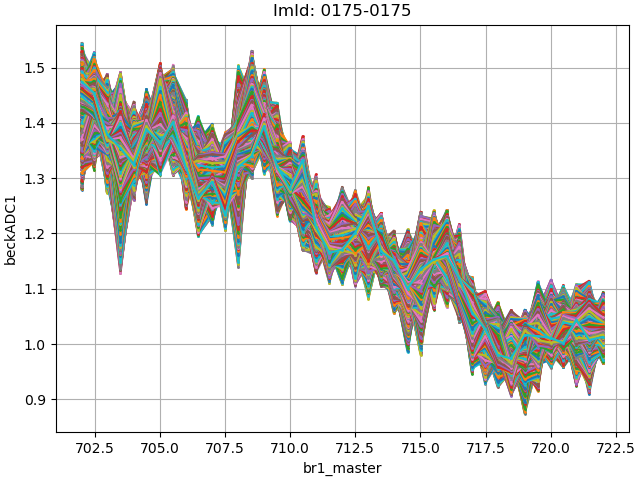

In [16]:
fig, ax = plt.subplots()

for i, _ in enumerate(scan_ids):
    ax.plot(xdata[i], ydata[i], "o-", markersize=1)
ax.set_title("ImId: %04d-%04d" % (scan_ids[0], scan_ids[-1]))
ax.set_xlabel(data_key_x)
ax.set_ylabel(data_key_y)
ax.grid()

fname = join(
    folder_general, "ImId_%04d-%04d_Diode_%s.png" % (scan_ids[0], scan_ids[-1], USER)
)
print("Saving: %s" % fname)
# plt.savefig(fname)

# Meshscans

In [119]:
scan_id = 316

diode = np.array(load_data(scan_id, "femto_beckhoff"))
max_sx = np.array(load_data(scan_id, "max_sx"))
max_sz = np.array(load_data(scan_id, "max_sz"))

Loaded field femto_beckhoff of /asap3/petra3/gpfs/p04/2023/data/11017820/raw/2305_moench_00316.nxs
Loaded field max_sx of /asap3/petra3/gpfs/p04/2023/data/11017820/raw/2305_moench_00316.nxs
Loaded field max_sz of /asap3/petra3/gpfs/p04/2023/data/11017820/raw/2305_moench_00316.nxs


Text(0, 0.5, 'max_sz')

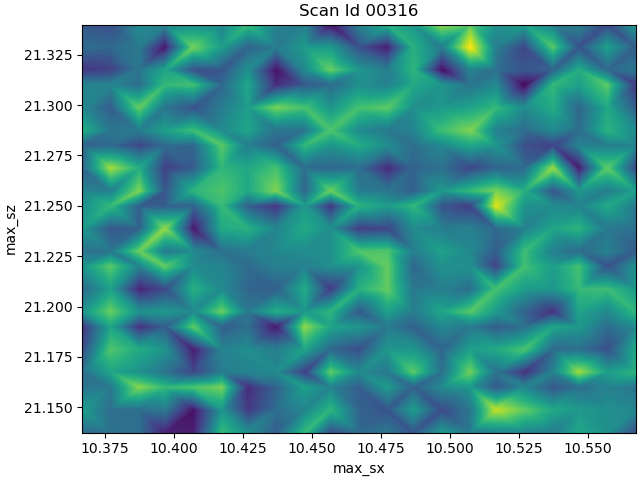

In [120]:
fig, ax = plt.subplots()
ax.tricontourf(max_sx, max_sz, diode, 100)
ax.set_title("Scan Id %05d" % scan_id)
ax.set_xlabel("max_sx")

ax.set_ylabel("max_sz")

Text(0, 0.5, 'max_sz')

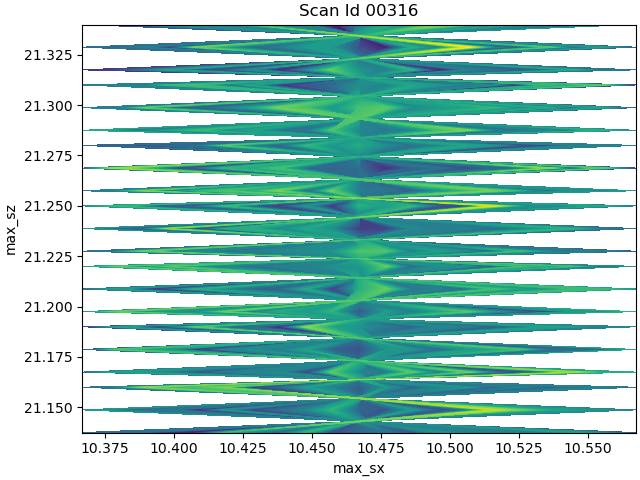

In [121]:
fig, ax = plt.subplots()
sx = np.reshape(max_sx, (21, 21))
sz = np.reshape(max_sz, (21, 21))
ddiode = np.reshape(diode, (21, 21))

ax.contourf(sx, sz, ddiode, 100)
ax.set_title("Scan Id %05d" % scan_id)
ax.set_xlabel("max_sx")
ax.set_ylabel("max_sz")